<a href="https://colab.research.google.com/github/zidnatuqoas/imageSegmentation_KM_SRM_weedDataset/blob/main/Image_segmentation_KM_SRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inisialisasi

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# COLAB
from google.colab import files
from google.colab import drive
# SYS
import sys
# IPYNB
!pip install import-ipynb
import import_ipynb
# UTIL
import importlib.util
# koneksi ke gdrive
sys.path.append('/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.5 MB/s eta 0:00:00


In [3]:
pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 40.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [4]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Preprocessing dengan Statistical Region Merging (SRM)

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import sys
import os
import random
import imageio 
from PIL import Image
# from SRM import SRM
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

**Membuat struktur data untuk menyimpan array citra**

In [ ]:
class UnionFind:
    """Union-find data structure. Struktur data untuk melacak dan menggabungkan kumpulan yang terpisah:
    - X[item] mengembalikan nama untuk set yang berisi item. 
      Setiap set diberi nama oleh salah satu anggotanya selama: set tetap sama dengan nama sama; 
      Jika item tersebut belum menjadi bagian dari set di X, set baru diciptakan
    - X.union(item1, item2, ...) : menggabungkan set setiap item menjadi satu set yang lebih besar. 
      Jika ada item yang belum menjadi bagian set itu, 
      maka akan ditambahkan ke X sebagai salah satu anggota himpunan gabungan
    """

    def __init__(self):
        """Membuat data struktur baru"""
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        """Mencari dan menembalikan nama himpunan yang berisi objek"""
        # check for previously unknown object
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root
        
    def __iter__(self):
        """Iterate through all items ever found or unioned by this structure."""
        return iter(self.parents)

    def union(self, *objects):
        """Find the sets containing the objects and merge them all."""
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r],r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest
        return heaviest

Preprocessing dengan Q=64

In [ ]:
import numpy

from UnionFind import UnionFind

class SRM:
    def __init__(self, image, Q=64.0):
        self._height = image.shape[0]
        self._width = image.shape[1]
        if image.ndim == 3:
            self._depth = image.shape[2]
        else:
            self._depth = 1
        
        self._n = self._width * self._height
        n = self._n
        self._image = image.reshape(n, -1)
        
        self._logdelta = 2.0 * numpy.log(6.0 * n)
        self._smallregion = int(0.001 * n)
        self._q = Q
    
    def run(self):
        self.initialization()
        self.segmentation()
        return self.finalize()
    
    def initialization(self):
        print("init")
        self._uf = UnionFind()
        uf = self._uf
        n = self._n
        height = self._height
        width = self._width
        depth = self._depth
        
        img = self._image
        self._data = numpy.empty([n, depth + 2])
        self._sizes = numpy.ones(n)
        
        for i in range(height):
            for j in range(width):
                idx = i * width + j
                uf[idx]
                self._data[idx, 0:depth] = img[idx]
                self._data[idx, depth ] = i
                self._data[idx, depth ] = j
    
    def segmentation(self):
        pairs = self.pairs()
        print("segmentation")
        
        for (r1, r2) in pairs:
            r1 = self._uf[r1]
            r2 = self._uf[r2]
            
            if r1 != r2 and self.predicate(r1, r2):
                self.merge(r1, r2)
        
        self.merge_small_regions()
    
    def pairs(self):
        print("pairs")
        pairs = []
        height = self._height
        width = self._width
        
        # using a C4-connectivity
        for i in range(height - 1):
            for j in range(width - 1):
                idx = i * width + j
                # left
                pairs.append( ( idx, i * width + j + 1) )
                
                # below
                pairs.append( ( idx, (i + 1) * width + j) )
        
        pairs = self.sort(pairs)
        return pairs
    
    def sort(self, pairs):
        print("sort")
        img = self._image
        def diff(p):
            (r1, r2) = p
            diff = numpy.max(numpy.abs(img[r1] - img[r2]))
            return diff
        return sorted(pairs, key=diff)
    
    def predicate(self, r1, r2):
        g = 256.0
        logdelta = self._logdelta
        
        w = self._sizes
        out = self._data
        
        d2 = (out[r1] - out[r2])**2
        
        log_r1 = min(g, w[r1]) * numpy.log(1.0 + w[r1])
        log_r2 = min(g, w[r2]) * numpy.log(1.0 + w[r2])
        
        q = self._q
        dev1 = g**2 / (2.0 * q * w[r1]) * (log_r1 + logdelta)
        dev2 = g**2 / (2.0 * q * w[r2]) * (log_r2 + logdelta)
        dev = dev1 + dev2
        
        return (d2 < dev).all()
    
    def merge(self, r1, r2):
        r = self._uf.union(r1, r2)
        
        s1 = self._sizes[r1]
        s2 = self._sizes[r2]
        n = s1 + s2
        self._data[r] = (s1 * self._data[r1] \
            + s2 * self._data[r2]) / n
        self._sizes[r] = n
    
    def merge_small_regions(self):
        print("small")
        
        height = self._height
        width = self._width
        smallregion = self._smallregion
        
        for i in range(self._height):
            for j in range(1, self._width):
                idx = i * width + j
                r1 = self._uf[idx]
                r2 = self._uf[idx - 1]
                
                if r1 != r2 and ( self._sizes[r1] < smallregion or self._sizes[r2] < smallregion):
                    self.merge(r1, r2)
    
    def finalize(self):
        print("finalize")
        
        height = self._height
        width = self._width
        depth = self._depth
        
        uf = self._uf
        data = self._data[:, 0:depth]
        out = numpy.empty([self._n, depth])
        for i in range(height):
            for j in range(1, width):
                idx = i * width + j
                r1 = uf[idx]
                out[idx] = data[r1]
        
        self._finalized = out.reshape(height, width, -1)
        return self._finalized
    
    def map(self):
        print("map")
        
        height = self._height
        width = self._width
        depth = self._depth
        
        classes = {}
        
        uf = self._uf
        data = self._data[:, 0:depth]
        out = numpy.empty(self._n)
        for i in range(height):
            for j in range(1, width):
                idx = i * width + j
                r1 = uf[idx]
                if r1 in classes:
                    classes[r1] += 1
                else:
                    classes[r1] = 1
                out[idx] = r1
        
        return classes, out.reshape(height, width)
    
    def exploded(self):
        print("exploded")
        
        out0 = numpy.empty([n, depth])
        out = self._data
        expl = numpy.zeros([2 * self._height, 2 * self._width, self._depth])
        
        for i in range(self._height):
            for j in range(1, self._width):
                r1 = self._uf[r]
                x = int(self._more[r1, 0])
                y = int(self._more[r1, 1])
                expl[i + x, j + y] = out[r]
        
        return expl



In [ ]:
def main():
    from scipy import ndimage, misc
    from imageio import imsave
    path = '/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset/dataset'
    outPath = '/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset/srm_64'
    for image_path in os.listdir(path):
        image = os.path.join(path, image_path)
        #image = numpy.array(image)
        image = plt.imread(image) #ndimage
        # SRM 
        srm = SRM(image, 256)
        segmented = srm.run()
        # print("Segmented SRM: ",segmented)
        segmented = numpy.uint8(segmented)
        fullpath = os.path.join(outPath, 'srm64_'+image_path)
        imageio.imsave(fullpath,segmented)
if __name__ == '__main__':
    main()

init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation


<ipython-input-19-1c2430eb478e>:96: RuntimeWarning: overflow encountered in square
  d2 = (out[r1] - out[r2])**2


small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
segmentation
small
finalize
init
pairs
sort
s

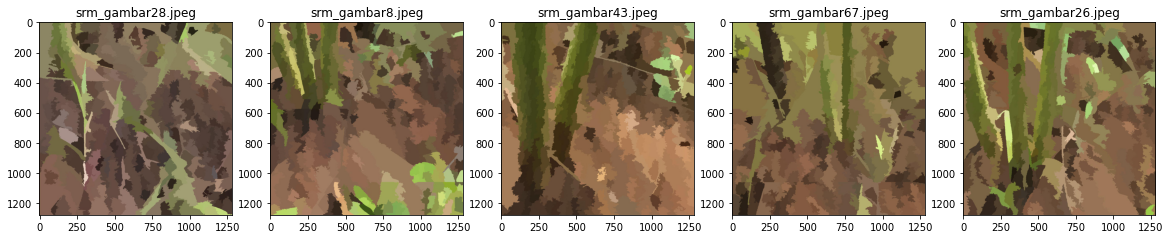

In [ ]:
plt.figure(figsize=(20,20))
test_folder=r'/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset/srm_64'
for i in range (5):
    file =random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

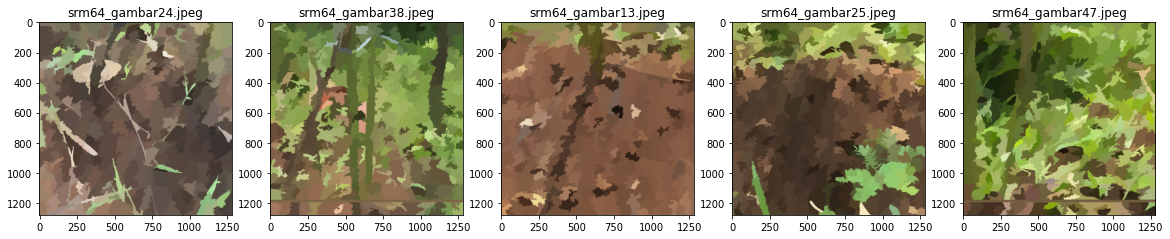

In [ ]:
plt.figure(figsize=(20,20))
test_folder=r'/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset/srm_64'
for i in range (5):
    file =random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

# Loading Data

In [ ]:
import numpy as np
import cv2 
import os
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import minmax_scale
import seaborn as sns
import warnings
folder_data = "/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset"
warnings.filterwarnings('ignore')

**Load dataset citra asli**

In [ ]:
from numpy.core.memmap import dtype
def load_data(path_dir):
  data = []
  for dir in os.listdir(folder_data): 
    for image in os.listdir(os.path.join(folder_data, dir)):
      image_path = os.path.join(folder_data, dir,image)
      im = cv2.imread(image_path,cv2.IMREAD_COLOR)
      im = cv2.resize(im, (150, 150), fx = 0.5, fy = 0.5)
      data.append(im)
    return data

**Load data preprocessing SRM**

In [ ]:
from scipy import ndimage, misc
def srm64_data (path_dir): 
  data2 = []
  for dir in os.listdir(folder_data): 
    for image in os.listdir(os.path.join(folder_data, dir)):
      image_path = os.path.join(folder_data, dir,image)
      image = plt.imread(image_path)
      srm = SRM(image, 256)
      segmented = srm.run()
      segmented = numpy.uint8(segmented)
      im = cv2.resize(segmented, (150, 150), fx = 0.5, fy = 0.5)
      data2.append(im)
    return data2

In [ ]:
path1 = "/dataset"
data = load_data(path1)
# datasrm = srm64_data(path1)

In [ ]:
data

[array([[[  7,  14,  10],
         [ 47,  75,  63],
         [ 65, 111,  84],
         ...,
         [ 65,  93,  78],
         [111, 155, 137],
         [166, 222, 202]],
 
        [[ 21,  56,  39],
         [ 76, 122,  99],
         [ 76, 134, 106],
         ...,
         [ 67,  98,  83],
         [158, 213, 198],
         [167, 222, 207]],
 
        [[ 70, 118,  90],
         [ 80, 135, 110],
         [142, 210, 183],
         ...,
         [113, 151, 139],
         [183, 236, 223],
         [168, 221, 208]],
 
        ...,
 
        [[117, 152, 201],
         [ 77, 117, 166],
         [121, 161, 214],
         ...,
         [125, 156, 207],
         [ 59,  88, 139],
         [113, 146, 196]],
 
        [[ 59,  91, 140],
         [ 40,  68, 114],
         [115, 150, 191],
         ...,
         [ 35,  64, 115],
         [130, 163, 213],
         [106, 139, 189]],
 
        [[135, 182, 240],
         [ 39,  70, 116],
         [ 33,  63, 109],
         ...,
         [ 63,  98, 148],
  

In [8]:
# Extract images from the dataset
X = []
for i in range(len(data)):
  X.append(np.ravel(data[i][0]))

# Extract images from the dataset SRM 
Xsrm64 = []
for i in range(len(datasrm)):
  Xsrm64.append(np.ravel(datasrm[i][0]))

NameError: ignored

In [ ]:
from sklearn.preprocessing import  minmax_scale

## Normalize the input, mean = 0, std = 1
X_scale = minmax_scale(X)
X_scale

array([[0.03763441, 0.        , 0.        , ..., 0.86315789, 0.8974359 ,
        0.86936937],
       [0.17741935, 0.11304348, 0.13692946, ..., 0.36842105, 0.29487179,
        0.41441441],
       [0.44623656, 0.43913043, 0.64315353, ..., 0.12105263, 0.11538462,
        0.20720721],
       ...,
       [0.21505376, 0.1826087 , 0.29045643, ..., 0.14210526, 0.29059829,
        0.28378378],
       [0.05913978, 0.16086957, 0.28630705, ..., 0.05789474, 0.05555556,
        0.13063063],
       [0.7311828 , 0.77826087, 0.65560166, ..., 0.18421053, 0.22222222,
        0.15765766]])

In [9]:
import pandas as pd
import numpy as np
# arr = np.asarray([ [7,8,9], [5,8,9] ])
# pd.DataFrame(Xsrm64).to_csv('srm.csv')  
# !cp srm.csv "/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset"
# pd.DataFrame(X).to_csv('citraasli.csv')
# !cp citraasli.csv "/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset"
X = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset/citraasli.csv')
print(X)
Xsrm64 = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset/srm.csv')
print(Xsrm64)

    Unnamed: 0    0    1   2    3    4    5    6    7    8  ...  440  441  \
0            0    7   14  10   47   75   63   65  111   84  ... -120   65   
1            1   33   40  43   36   43   46   44   48   49  ...   88   78   
2            2   83  115 -91   49   81  124   69   89  116  ...  -78   51   
3            3  -78  -37 -35 -118  -81  -74   78  105 -115  ...   70   42   
4            4   25   80  87   22   78   84   28   83   90  ...   12    5   
..         ...  ...  ...  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...   
75          75   24   41  37   36   68   61  112 -122 -120  ...   47   24   
76          76   27   60  56   26   68   63  123  -90 -111  ...   20   80   
77          77   40   56  80   34   48   67   30   40   58  ...   82   35   
78          78   11   51  79 -121  -76  -35   68  118  -96  ...   34    8   
79          79 -120  -63 -88   51  109   83   22   55   34  ...   32    5   

    442  443  444  445  446  447  448  449  
0    93   78  111 -101 -119  -

In [10]:
len(Xsrm64)

80

In [11]:
from sklearn.preprocessing import  minmax_scale

## Normalize the input, mean = 0, std = 1
X_scale = minmax_scale(X)
Xsrm64_scale = minmax_scale(Xsrm64)

In [ ]:
X_scale 

array([[0.        , 0.54065041, 0.5708502 , ..., 0.10041841, 0.37450199,
        0.2811245 ],
       [0.01265823, 0.64634146, 0.67611336, ..., 0.77824268, 0.83266932,
        0.90361446],
       [0.02531646, 0.8495935 , 0.97975709, ..., 0.58158996, 0.66533865,
        0.7188755 ],
       ...,
       [0.97468354, 0.67479675, 0.74089069, ..., 0.59832636, 0.82868526,
        0.78714859],
       [0.98734177, 0.55691057, 0.72064777, ..., 0.53138075, 0.60956175,
        0.65060241],
       [1.        , 0.02439024, 0.25910931, ..., 0.63179916, 0.76494024,
        0.6746988 ]])

In [ ]:
Xsrm64_scale

array([[0.        , 0.02352941, 0.03921569, ..., 0.01968504, 0.03921569,
        0.82608696],
       [0.01265823, 1.        , 0.94117647, ..., 1.        , 0.94117647,
        0.85770751],
       [0.02531646, 0.98039216, 0.86666667, ..., 0.98031496, 0.86666667,
        0.743083  ],
       ...,
       [0.97468354, 0.03137255, 0.89803922, ..., 0.92125984, 0.90980392,
        0.74703557],
       [0.98734177, 0.12156863, 0.09019608, ..., 0.87007874, 0.89019608,
        0.68379447],
       [1.        , 0.92156863, 0.        , ..., 0.81496063, 0.89411765,
        0.72727273]])

# Elbow method 

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
sns.set(rc = {'figure.figsize':(15,8)})
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

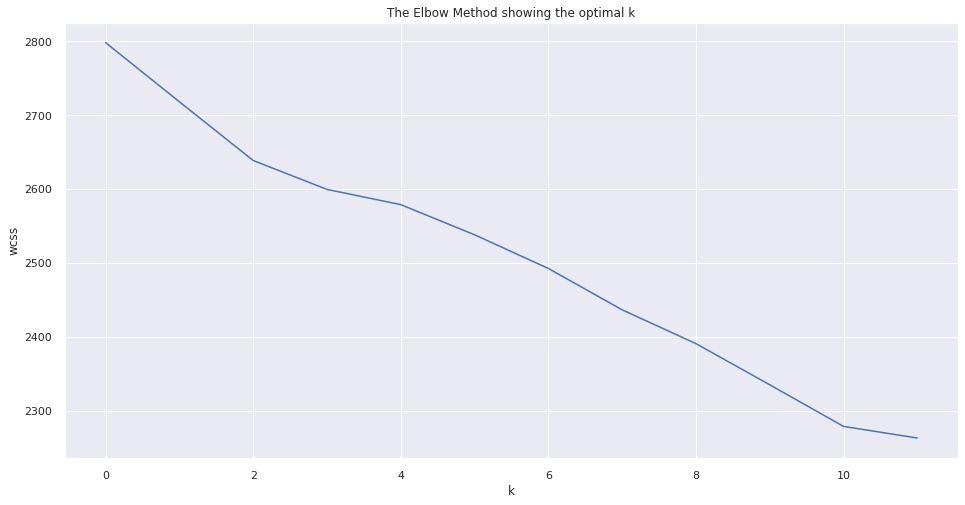

In [13]:
from sklearn.cluster import KMeans
wcss = [] 
for i in range(1, 13): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_scale) 
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(16,8))
plt.plot(wcss, 'bx-')
plt.xlabel('k')
plt.ylabel('wcss')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [14]:
wcss

[2798.324968361445,
 2718.2329221153122,
 2638.7692792276503,
 2599.6355546373766,
 2579.018324432388,
 2538.179953680239,
 2492.5643371282367,
 2436.5902579067238,
 2390.7948236218244,
 2335.073707423664,
 2278.6999039960474,
 2262.9419936251097]

Bisa kita lihat saat k=1 bahwa nilai wcss tinggi. Kemudian menurun signifikan sampai k = 3. secara visual terlihat membentuk siku. berikutnya mulai k=4 sampai k=12 penurunan skokr WCSS sudah tidak begitu signifikan. Jadi k optimal terletak pada k = 3

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

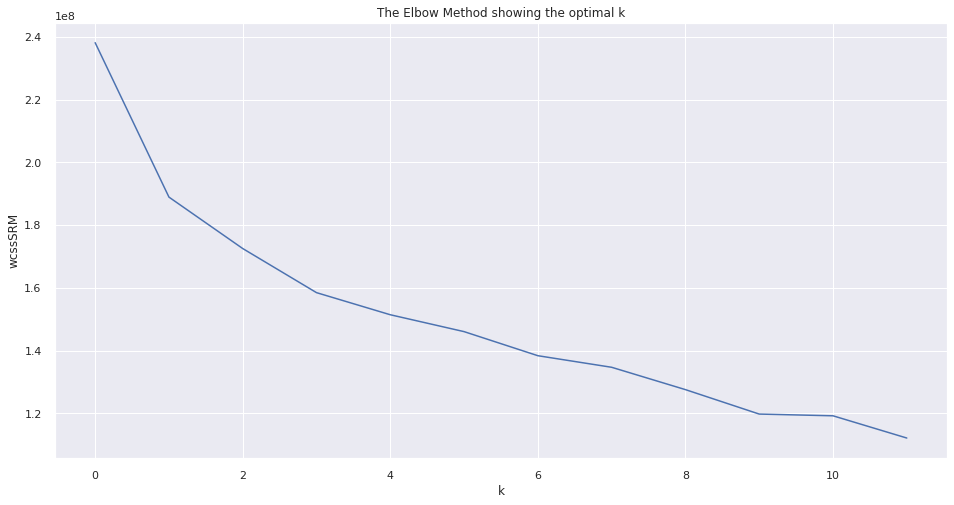

In [15]:
from sklearn.cluster import KMeans
wcssSRM = [] 
for i in range(1, 13): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(Xsrm64) 
    wcssSRM.append(kmeans.inertia_)
plt.figure(figsize=(16,8))
plt.plot(wcssSRM, 'bx-')
plt.xlabel('k')
plt.ylabel('wcssSRM')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [16]:
wcssSRM

[238191491.95,
 188951737.50943393,
 172544891.99166667,
 158480717.85701758,
 151433006.08468467,
 146049840.41153127,
 138371404.11709842,
 134679404.7920635,
 127555491.27222222,
 119760297.1940171,
 119208419.0507326,
 112118557.9]

Bisa kita lihat saat k=1 bahwa nilai wcss tinggi. Kemudian menurun signifikan pada berikutnya k = 2. secara visual terlihat membentuk siku. berikutnya mulai k=3 sampai k=12 penurunan skokr WCSS sudah tidak begitu signifikan. Jadi k optimal terletak pada k = 2 

**Elbow plot**
Klastering dnegan K-means sensitif terhadap menentukan awal K. Oleh karena itu untuk mencari k yang optimal dapat menggunakan Elbow plot 

Pada hasil elbow plot diatas dapat dilihat  dengan cluster berbeda. Dari visual diatas dapat diliat **antara klaster 2 dan 3 mewakili jumlah yang optimal** **karena plot siku memiliki kemiringan yang lebih tajam** pada nilai tersebut.
Saya akan melatih model dengan keduanya dan melihat perbedaan hasil evaluasinya. 
Saya menambahkan k = 8 sebagai bahan perbandingan lain. 

# Model KM

**Model KM dengan k 2, 3, 4 dan iter max 100**

In [17]:
# Membuat prediksi pada dataset asli sebelum preprocessing SRM 
# k = 2 dan max iter 100 
kmeans_2_100 = KMeans(init='k-means++',n_clusters=2,n_init=10,max_iter=100,random_state=42)
model_2_100 = kmeans_2_100.fit(X_scale)
km_pred_2_100= kmeans_2_100.fit_predict(X_scale)  
labels_km_2_100 = model_2_100.labels_

# dimulai dengan k = 3 dan max iter 100
kmeans_3_100 = KMeans(init='k-means++',n_clusters=3,n_init=10,max_iter=100,random_state=42)
# melatih model 
model_3_100 = kmeans_3_100.fit(X_scale)
km_pred_3_100= kmeans_3_100.fit_predict(X_scale)  
labels_km_3_100 = model_3_100.labels_

kmeans_4_100 = KMeans(init='k-means++',n_clusters=4,n_init=10,max_iter=100,random_state=42)
# melatih model 
model_4_100 = kmeans_4_100.fit(X_scale)
km_pred_4_100= kmeans_4_100.fit_predict(X_scale)  
labels_km_4_100 = model_4_100.labels_

In [18]:
# Membuat prediksi pada dataset asli sebelum preprocessing SRM 
# k = 2 dan max iter 300 
kmeans_2_300 = KMeans(init='k-means++',n_clusters=2,n_init=10,max_iter=300,random_state=42)
model_2_300 = kmeans_2_300.fit(X_scale)
km_pred_2_300= kmeans_2_300.fit_predict(X_scale)  
labels_km_2_300 = model_2_300.labels_

# dimulai dengan k = 3 dan max iter 300
kmeans_3_300 = KMeans(init='k-means++',n_clusters=3,n_init=10,max_iter=300,random_state=42)
# melatih model 
model_3_300 = kmeans_3_300.fit(X_scale)
km_pred_3_300= kmeans_3_300.fit_predict(X_scale)  
labels_km_3_300 = model_3_300.labels_

kmeans_4_300 = KMeans(init='k-means++',n_clusters=4,n_init=10,max_iter=300,random_state=42)
# melatih model 
model_4_300 = kmeans_4_300.fit(X_scale)
km_pred_4_300= kmeans_4_300.fit_predict(X_scale)  
labels_km_4_300 = model_4_300.labels_

# Model SRMKM

**Model SRMKM dengan k 2, 3, 4 dan iter max 100**

In [19]:
# Membuat prediksi pada dataset asli sebelum preprocessing SRM 
# k = 2 dan max iter 100 
srmkmeans_2_100 = KMeans(init='k-means++',n_clusters=2,n_init=10,max_iter=100,random_state=42)
srmmodel_2_100 = srmkmeans_2_100.fit(Xsrm64_scale)
srmkm_pred_2_100= srmkmeans_2_100.fit_predict(Xsrm64_scale)  
labels_srmkm_2_100 = srmmodel_2_100.labels_

# dimulai dengan k = 3 dan max iter 100
srmkmeans_3_100 = KMeans(init='k-means++',n_clusters=3,n_init=10,max_iter=100,random_state=42)
# melatih model 
srmmodel_3_100 = srmkmeans_3_100.fit(Xsrm64_scale)
srmkm_pred_3_100= srmkmeans_3_100.fit_predict(Xsrm64_scale)  
labels_srmkm_3_100 = srmmodel_3_100.labels_

srmkmeans_4_100 = KMeans(init='k-means++',n_clusters=4,n_init=10,max_iter=100,random_state=42)
# melatih model 
srmmodel_4_100 = srmkmeans_4_100.fit(Xsrm64_scale)
srmkm_pred_4_100= srmkmeans_4_100.fit_predict(Xsrm64_scale)  
labels_srmkm_4_100 = srmmodel_4_100.labels_

**Model SRMKM dengan k 2, 3, 4 dan iter max 300**

In [20]:
# Membuat prediksi pada dataset asli sebelum preprocessing SRM 
# k = 2 dan max iter 300 
srmkmeans_2_300 = KMeans(init='k-means++',n_clusters=2,n_init=10,max_iter=300,random_state=42)
srmmodel_2_300 = srmkmeans_2_300.fit(Xsrm64_scale)
srmkm_pred_2_300= srmkmeans_2_300.fit_predict(Xsrm64_scale)  
labels_srmkm_2_300 = srmmodel_2_300.labels_

# dimulai dengan k = 3 dan max iter 300
srmkmeans_3_300 = KMeans(init='k-means++',n_clusters=3,n_init=10,max_iter=300,random_state=42)
# melatih model 
srmmodel_3_300 = srmkmeans_3_300.fit(Xsrm64_scale)
srmkm_pred_3_300= srmkmeans_3_300.fit_predict(Xsrm64_scale)  
labels_srmkm_3_300 = srmmodel_3_300.labels_

srmkmeans_4_300 = KMeans(init='k-means++',n_clusters=4,n_init=10,max_iter=300,random_state=42)
# melatih model 
srmmodel_4_300 = srmkmeans_4_300.fit(Xsrm64_scale)
srmkm_pred_4_300= srmkmeans_4_300.fit_predict(Xsrm64_scale)  
labels_srmkm_4_300 = srmmodel_4_300.labels_

# Evaluasi Validasi CLuster

In [21]:
from itertools import product
from math import log

# NumPy, SciPy and Pandas
import numpy as np
import pandas as pd

# Scikit-Learn
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import pairwise_distances

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def divide(data, labels):
    clusters = set(labels)
    clusters_data = []
    for cluster in clusters:
        clusters_data.append(data[labels == cluster, :])
    return clusters_data

def get_centroids(clusters):
    centroids = []
    for cluster_data in clusters:
        centroids.append(cluster_data.mean(axis=0))
    return centroids

In [23]:
## kohesi yaitu seberapa mirip/seberapa dekat hubungan data dengan suatu klaster
## semakin dekat semakin bagus 
def cohesion(data, labels):
    clusters = sorted(set(labels))
    sse = 0
    for cluster in clusters:
        cluster_data = data[labels == cluster, :]
        centroid = cluster_data.mean(axis = 0)
        sse += ((cluster_data - centroid)**2).sum()
    return sse

## Separasi yaitu seberapa berbeda/seberapa bagus keterpisahan sebuah klaster
## semakin beda/besar nilainya semakin bagus 
def separation(data, labels, cohesion_score):
    return cohesion(data, np.zeros(data.shape[0])) - cohesion_score

def SST(data):
    c = get_centroids([data])
    return ((data - c) ** 2).sum()

def SSE(clusters, centroids):
    result = 0
    for cluster, centroid in zip(clusters, centroids):
        result += ((cluster - centroid) ** 2).sum()
    return result

within_cluster_dist_sum_store = {}
def within_cluster_dist_sum(cluster, centroid, cluster_id):
    if cluster_id in within_cluster_dist_sum_store:
        return within_cluster_dist_sum_store[cluster_id]
    else:
        result = (((cluster - centroid) ** 2).sum(axis=1)**.5).sum()
        within_cluster_dist_sum_store[cluster_id] = result
    return result

def RMSSTD(data, clusters, centroids):
    df = data.shape[0] - len(clusters)
    attribute_num = data.shape[1]
    return (SSE(clusters, centroids) / (attribute_num * df)) ** .5

# equal to separation / (cohesion + separation)
def RS(data, clusters, centroids):
    sst = SST(data)
    sse = SSE(clusters, centroids)
    return (sst - sse) / sst

def DB_find_max_j(clusters, centroids, i):
    max_val = 0
    max_j = 0
    for j in range(len(clusters)):
        if j == i:
            continue
        cluster_i_stat = within_cluster_dist_sum(clusters[i], centroids[i], i) / clusters[i].shape[0]
        cluster_j_stat = within_cluster_dist_sum(clusters[j], centroids[j], j) / clusters[j].shape[0]
        val = (cluster_i_stat + cluster_j_stat) / (((centroids[i] - centroids[j]) ** 2).sum() ** .5)
        if val > max_val:
            max_val = val
            max_j = j
    return max_val

def DB(data, clusters, centroids):
    result = 0
    for i in range(len(clusters)):
        result += DB_find_max_j(clusters, centroids, i)
    return result / len(clusters)

def XB(data, clusters, centroids):
    sse = SSE(clusters, centroids)
    min_dist = ((centroids[0] - centroids[1]) ** 2).sum()
    for centroid_i, centroid_j in list(product(centroids, centroids)):
        if (centroid_i - centroid_j).sum() == 0:
            continue
        dist = ((centroid_i - centroid_j) ** 2).sum()
        if dist < min_dist:
            min_dist = dist
    return sse / (data.shape[0] * min_dist)

def get_validation_scores(data, labels):
    within_cluster_dist_sum_store.clear()
    
    clusters = divide(data, labels)
    centroids = get_centroids(clusters)
    
    scores = {}

    scores['cohesion'] = cohesion(data, labels)
    scores['separation'] = separation(data, labels, scores['cohesion'])
    scores['DB'] = DB(data, clusters, centroids)
    scores['XB'] = XB(data, clusters, centroids)
    
    return scores

In [24]:
v_km_2_100 = get_validation_scores(X_scale, labels_km_2_100)
v_km_3_100 = get_validation_scores(X_scale, labels_km_3_100)
v_km_4_100 = get_validation_scores(X_scale, labels_km_4_100)

v_srmkm_2_100 = get_validation_scores(Xsrm64_scale, labels_srmkm_2_100)
v_srmkm_3_100 = get_validation_scores(Xsrm64_scale, labels_srmkm_3_100)
v_srmkm_4_100 = get_validation_scores(Xsrm64_scale, labels_srmkm_4_100)

v_km_2_300 = get_validation_scores(X_scale, labels_km_2_300)
v_km_3_300 = get_validation_scores(X_scale, labels_km_3_300)
v_km_4_300 = get_validation_scores(X_scale, labels_km_4_300)

v_srmkm_2_300 = get_validation_scores(Xsrm64_scale, labels_srmkm_2_300)
v_srmkm_3_300 = get_validation_scores(Xsrm64_scale, labels_srmkm_3_300)
v_srmkm_4_300 = get_validation_scores(Xsrm64_scale, labels_srmkm_4_300)

# FCM
# v_fcm_2_100 = get_validation_scores(X_scale, fcm_2_100_labels)
# v_fcm_3_100 = get_validation_scores(X_scale, fcm_3_100_labels)
# v_fcm_4_100 = get_validation_scores(X_scale, fcm_4_100_labels)

# v_srmfcm_2_100 = get_validation_scores(Xsrm64_scale, srmfcm_2_100_labels)
# v_srmfcm_3_100 = get_validation_scores(Xsrm64_scale, srmfcm_3_100_labels)
# v_srmfcm_4_100 = get_validation_scores(Xsrm64_scale, srmfcm_4_100_labels)

# v_fcm_2_300 = get_validation_scores(X_scale, fcm_2_300_labels)
# v_fcm_3_300 = get_validation_scores(X_scale, fcm_3_300_labels)
# v_fcm_4_300 = get_validation_scores(X_scale, fcm_4_300_labels)

# v_srmfcm_2_300 = get_validation_scores(Xsrm64_scale, srmfcm_2_300_labels)
# v_srmfcm_3_300 = get_validation_scores(Xsrm64_scale, srmfcm_3_300_labels)
# v_srmfcm_4_300 = get_validation_scores(Xsrm64_scale, srmfcm_4_300_labels)

print("Model uji km_2_100: ",v_km_2_100)
print("Model uji km_3_100: ",v_km_3_100)
print("Model uji km_4_100: ",v_km_4_100)

print("Model uji km_2_300: ",v_km_2_300)
print("Model uji km_3_300: ",v_km_3_300)
print("Model uji km_4_300: ",v_km_4_300)

print("Model uji srmkm_2_100: ",v_srmkm_2_100)
print("Model uji srmkm_3_100: ",v_srmkm_3_100)
print("Model uji srmkm_4_100: ",v_srmkm_4_100)

print("Model uji srmkm_2_300: ",v_srmkm_2_300)
print("Model uji srmkm_3_300: ",v_srmkm_3_300)
print("Model uji srmkm_4_300: ",v_srmkm_4_300)

#FCM
# print("Model uji fcm_2_100: ",v_fcm_2_100)
# print("Model uji fcm_3_100: ",v_fcm_3_100)
# print("Model uji fcm_4_100: ",v_fcm_4_100)

# print("Model uji fcm_2_300: ",v_fcm_2_300)
# print("Model uji fcm_3_300: ",v_fcm_3_300)
# print("Model uji fcm_4_300: ",v_fcm_4_300)

# print("Model ujix srmfcm_2_100: ",v_srmfcm_2_100)
# print("Model uji srmfcm_3_100: ",v_srmfcm_3_100)
# print("Model uji srmfcm_4_100: ",v_srmfcm_4_100)

# print("Model uji srmfcm_2_300: ",v_srmfcm_2_300)
# print("Model uji srmfcm_3_300: ",v_srmfcm_3_300)
# print("Model uji srmfcm_4_300: ",v_srmfcm_4_300)

Model uji km_2_100:  {'cohesion': 2718.2329221153113, 'separation': 80.09204624613312, 'DB': 4.497071291274017, 'XB': 4.899923232381482}
Model uji km_3_100:  {'cohesion': 2638.7692792276507, 'separation': 159.55568913379375, 'DB': 4.3723809371029025, 'XB': 5.625266648614522}
Model uji km_4_100:  {'cohesion': 2599.6355546373766, 'separation': 198.6894137240679, 'DB': 3.833929149956502, 'XB': 4.597561998864241}
Model uji km_2_300:  {'cohesion': 2718.2329221153113, 'separation': 80.09204624613312, 'DB': 4.497071291274017, 'XB': 4.899923232381482}
Model uji km_3_300:  {'cohesion': 2638.7692792276507, 'separation': 159.55568913379375, 'DB': 4.3723809371029025, 'XB': 5.625266648614522}
Model uji km_4_300:  {'cohesion': 2599.6355546373766, 'separation': 198.6894137240679, 'DB': 3.833929149956502, 'XB': 4.597561998864241}
Model uji srmkm_2_100:  {'cohesion': 3204.6507922646338, 'separation': 815.6424206118913, 'DB': 1.8705361571647776, 'XB': 0.8784975743970921}
Model uji srmkm_3_100:  {'cohesi

In [29]:
scores = [["KM", v_km_2_100, v_km_3_100, v_km_4_100, v_km_2_300, v_km_3_300, v_km_4_300],
          ["SRMKM", v_srmkm_2_100, v_srmkm_3_100, v_srmkm_4_100, v_srmkm_2_300, v_srmkm_3_300, v_srmkm_4_300]]
scores_df = pd.DataFrame(scores, columns = ["Model", "k = 2, Max_iter = 100", "k = 3, Max_iter = 100", "k = 4, Max_iter = 100", "k = 2, Max_iter = 300", "k = 3, Max_iter = 300", "k = 4, Max_iter = 300"])
scores_df

,Model,"k = 2, Max_iter = 100","k = 3, Max_iter = 100","k = 4, Max_iter = 100","k = 2, Max_iter = 300","k = 3, Max_iter = 300","k = 4, Max_iter = 300"
0,KM,"{'cohesion': 2718.2329221153113, 'separation':...","{'cohesion': 2638.7692792276507, 'separation':...","{'cohesion': 2599.6355546373766, 'separation':...","{'cohesion': 2718.2329221153113, 'separation':...","{'cohesion': 2638.7692792276507, 'separation':...","{'cohesion': 2599.6355546373766, 'separation':..."
1,SRMKM,"{'cohesion': 3204.6507922646338, 'separation':...","{'cohesion': 2922.7192421363425, 'separation':...","{'cohesion': 2703.0281442629093, 'separation':...","{'cohesion': 3204.6507922646338, 'separation':...","{'cohesion': 2922.7192421363425, 'separation':...","{'cohesion': 2703.0281442629093, 'separation':..."


Pengertian DB Index : 
Indeks validitas Davies-Bouldin (DB) **menghitung rata-rata nilai setiap titik pada himpunan data.** 
Perhitungan nilai setiap titik adalah jumlah nilai compactness yang dibagi dengan jarak antara kedua titik pusat klaster sebagai separation. 
**Jumlah klaster terbaik ditunjukkan dengan nilai DB yang semakin kecil** 

**Kesimpulan**

Dari hasil percobaan klastering dengan Kmeans dan Fuzzy C-Means dengan preprocessing SRM, dapat disimpulkan bahwa: 
- Elbow plot menunjukan nilai k optimum ditunjukan pada k = 2
- Klaster terbaik ditunjukan c = 2 dengan model SRMKM dengan nilai index DB 0.878
- Model dengan data yang dipreprocessing dengan SRM lebih baik dari pada yang tanpa SRM. 

**Visualisasi pada citra asli dengan model uji km_4_300**

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import scatterplot as scatter
import sys

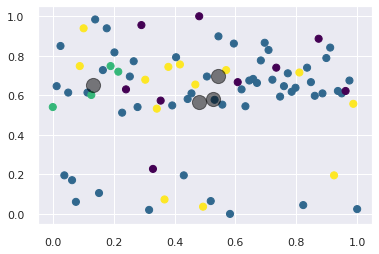

In [36]:
plt.scatter(X_scale[:, 0], X_scale[:, 1], c=km_pred_4_300, s=50, cmap='viridis')
centers = kmeans_4_300.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


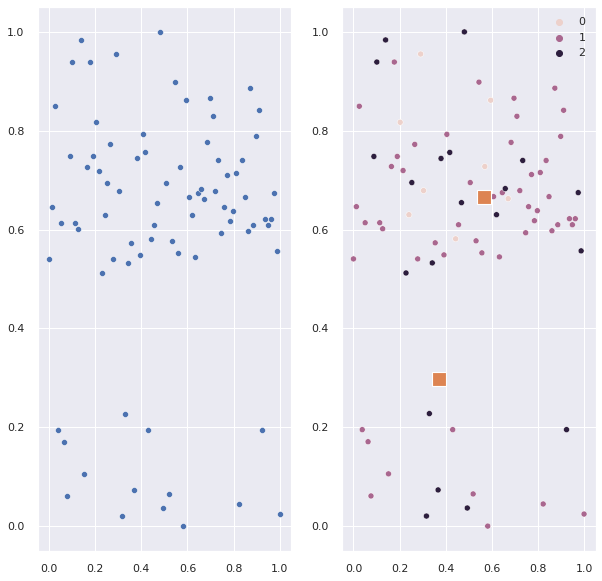

In [41]:
f, axes, = plt.subplots(1,2, figsize=(10,10))
scatter(X_scale[:,0], X_scale[:,1], ax = axes[0])
scatter(X_scale[:,0], X_scale[:,1], ax = axes[1], hue=labels_km_3_300)
scatter(centers[:,0], centers[:,1], ax=axes[1], marker="s", s=200)
plt.show()

**Visualisasi pada citra SRM dengan model uji srmkm_2_300**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


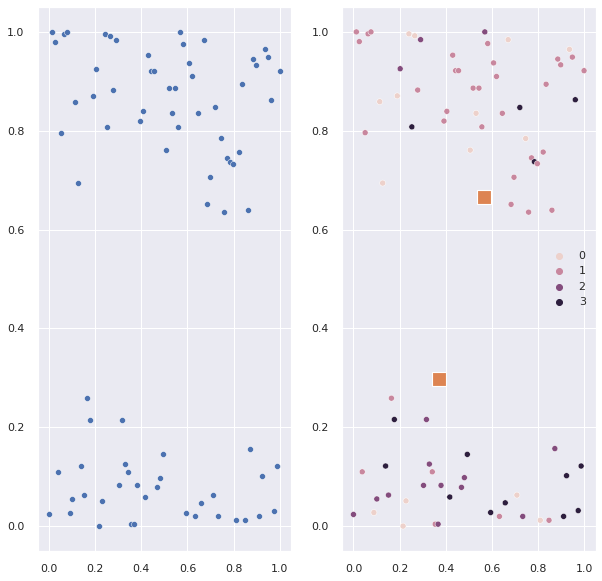

In [42]:
f, axes, = plt.subplots(1,2, figsize=(10,10))
scatter(Xsrm64_scale[:,0], Xsrm64_scale[:,1], ax = axes[0])
scatter(Xsrm64_scale[:,0], Xsrm64_scale[:,1], ax = axes[1], hue=labels_srmkm_4_300)
scatter(centers[:,0], centers[:,1], ax=axes[1], marker="s", s=200)
plt.show()

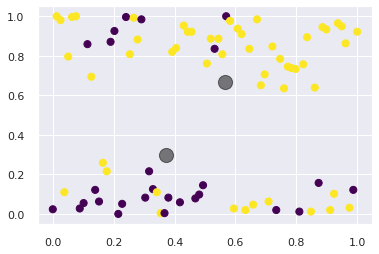

In [43]:
plt.scatter(Xsrm64_scale[:, 0], Xsrm64_scale[:, 1], c=srmkm_pred_2_300, s=50, cmap='viridis')
centers = srmkmeans_2_300.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

# Segmented Image KM

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio 
from scipy import ndimage, misc
from timeit import default_timer as timer

**SEGMENTASI DENGAN KM TANPA SRM, K = 4**

In [ ]:
def km_4_300():
    starttotal_km_4_300 = time.time()
    from scipy import ndimage
    # from imageio import imsave
    path = '/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset/dataset'
    outPath = '/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset/km(k4_300)'

    for img_path in os.listdir(path):
        start_km_4_300 = time.time()
        # create the full input path and read the file
        image = os.path.join(path, img_path)
        image=plt.imread(image)
        # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
        pixel_vals = image.reshape((-1,3))
        # Convert to float type
        pixel_vals = np.float32(pixel_vals)
        # kriteria algoritma untuk berhenti berjalan, yang akan terjadi 100 iterasi yang berjalan atau epsilon menjadi 85%
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.85)
        # k-means clustering dengan number cluster 
        #inisialisasi centroid dengan intensitas acak k
        k = 4
        retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        # convert data into 8-bit values 
        centers = np.uint8(centers)
        # convert all pixel to the color of the centroids
        segmented_image = centers[labels.flatten()]
        # reshape back to the original image dimensions
        segmented_image = segmented_image.reshape((image.shape))
        fullpath = os.path.join(outPath, 'km(k4_300)_'+img_path)
        cv2.imwrite(fullpath,segmented_image)
        end_km_4_300 = time.time()
        time_of_execution_km_4_300 = end_km_4_300 - start_km_4_300
        print(time_of_execution_km_4_300, "seconds for km_4_300")
        plt.show()  
    endtotal_km_4_300 = timer()
    print(endtotal_km_4_300, "total seconds for km_4_300")

if __name__ == '__main__':
  km_4_300()

In [ ]:
def srmkm_2_300():
    starttotal_srmkm_2_300 = time.time()
    from scipy import ndimage
    # from imageio import imsave
    path = '/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset/srm_64'
    outPath = '/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset/srmkm(k2_300)'

    for img_path in os.listdir(path):
        start_srmkm_2_300 = time.time()
        # create the full input path and read the file
        image = os.path.join(path, img_path)
        image=plt.imread(image)
        # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
        pixel_vals = image.reshape((-1,3))
        # Convert to float type
        pixel_vals = np.float32(pixel_vals)
        # kriteria algoritma untuk berhenti berjalan, yang akan terjadi 100 iterasi yang berjalan atau epsilon menjadi 85%
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.85)
        # k-means clustering dengan number cluster 
        #inisialisasi centroid dengan intensitas acak k
        k = 2
        retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        # convert data into 8-bit values 
        centers = np.uint8(centers)
        # convert all pixel to the color of the centroids
        segmented_image = centers[labels.flatten()]
        # reshape back to the original image dimensions
        segmented_image = segmented_image.reshape((image.shape))
        fullpath = os.path.join(outPath, 'srmkm_2_300'+img_path)
        cv2.imwrite(fullpath,segmented_image)
        end_srmkm_2_300 = time.time()
        time_of_execution_srmkm_2_300 = end_srmkm_2_300 - start_srmkm_2_300
        print(time_of_execution_srmkm_2_300, "seconds for srmkm_4_300")
        plt.show()  
    endtotal_srmkm_2_300 = timer()
    total_time_srmkm_2_300=endtotal_srmkm_2_300-starttotal_srmkm_2_300
    print(total_time_srmkm_2_300, "total seconds for srmkm_2_300")

if __name__ == '__main__':
  srmkm_2_300()

# Segmentasi sampel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio 
from scipy import ndimage, misc
from timeit import default_timer as timer

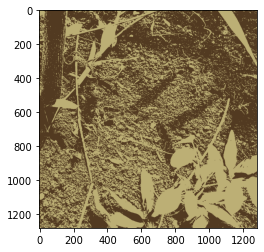

In [ ]:
path_sample = '/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset/dataset/gambar27.jpeg'
sample_1 = os.path.join(path_sample)
sample_1=plt.imread(sample_1)
pixel_vals = sample_1.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.85)
k = 2
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
segmented_image1 = centers[labels.flatten()]
segmented_image1 = segmented_image1.reshape((sample_1.shape))
segmented_image1
plt.imshow(segmented_image1)

In [ ]:
s_image1_array = np.float32(segmented_image1)
s_image1_array

array([[[188., 175., 117.],
        [188., 175., 117.],
        [188., 175., 117.],
        ...,
        [ 83.,  59.,  33.],
        [ 83.,  59.,  33.],
        [ 83.,  59.,  33.]],

       [[188., 175., 117.],
        [188., 175., 117.],
        [188., 175., 117.],
        ...,
        [ 83.,  59.,  33.],
        [ 83.,  59.,  33.],
        [ 83.,  59.,  33.]],

       [[188., 175., 117.],
        [188., 175., 117.],
        [188., 175., 117.],
        ...,
        [ 83.,  59.,  33.],
        [ 83.,  59.,  33.],
        [ 83.,  59.,  33.]],

       ...,

       [[188., 175., 117.],
        [188., 175., 117.],
        [188., 175., 117.],
        ...,
        [ 83.,  59.,  33.],
        [ 83.,  59.,  33.],
        [ 83.,  59.,  33.]],

       [[188., 175., 117.],
        [188., 175., 117.],
        [188., 175., 117.],
        ...,
        [ 83.,  59.,  33.],
        [ 83.,  59.,  33.],
        [ 83.,  59.,  33.]],

       [[188., 175., 117.],
        [188., 175., 117.],
        [188., 1

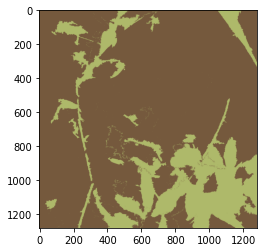

In [ ]:
path_sample = '/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset/srm_64/srm64_gambar27.jpeg'
sample_2 = os.path.join(path_sample)
sample_2 = plt.imread(sample_2)
pixel_vals = sample_2.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.85)
k = 2
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
segmented_image2 = centers[labels.flatten()]
segmented_image2 = segmented_image2.reshape((sample_2.shape))
segmented_image2
plt.imshow(segmented_image2)

In [ ]:
s_image2_array = np.float32(segmentedsrm_image1)
s_image2_array

array([[[117.,  89.,  61.],
        [117.,  89.,  61.],
        [117.,  89.,  61.],
        ...,
        [117.,  89.,  61.],
        [117.,  89.,  61.],
        [117.,  89.,  61.]],

       [[117.,  89.,  61.],
        [117.,  89.,  61.],
        [117.,  89.,  61.],
        ...,
        [117.,  89.,  61.],
        [117.,  89.,  61.],
        [117.,  89.,  61.]],

       [[117.,  89.,  61.],
        [117.,  89.,  61.],
        [117.,  89.,  61.],
        ...,
        [117.,  89.,  61.],
        [117.,  89.,  61.],
        [117.,  89.,  61.]],

       ...,

       [[117.,  89.,  61.],
        [117.,  89.,  61.],
        [117.,  89.,  61.],
        ...,
        [117.,  89.,  61.],
        [117.,  89.,  61.],
        [117.,  89.,  61.]],

       [[117.,  89.,  61.],
        [117.,  89.,  61.],
        [117.,  89.,  61.],
        ...,
        [117.,  89.,  61.],
        [117.,  89.,  61.],
        [117.,  89.,  61.]],

       [[117.,  89.,  61.],
        [117.,  89.,  61.],
        [117.,  

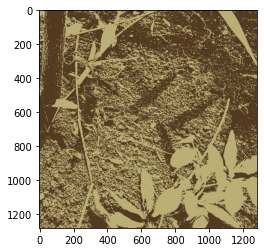

In [ ]:
path_sample = '/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset/dataset/gambar27.jpeg'
sample_1 = os.path.join(path_sample)
sample_1=plt.imread(sample_1)
pixel_vals = sample_1.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.85)
k = 2
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
segmented_image1 = centers[labels.flatten()]
segmented_image1 = segmented_image1.reshape((sample_1.shape))
segmented_image1
plt.imshow(segmented_image1)

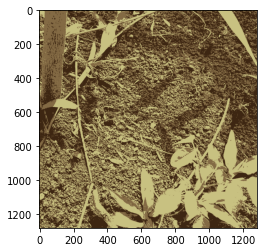

In [ ]:
path_sample = '/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset/dataset/gambar27.jpeg'
sample_1 = os.path.join(path_sample)
sample_1=plt.imread(sample_1)
pixel_vals = sample_1.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.85)
k = 3
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
segmented_image1 = centers[labels.flatten()]
segmented_image1 = segmented_image1.reshape((sample_1.shape))
segmented_image1
plt.imshow(segmented_image1)

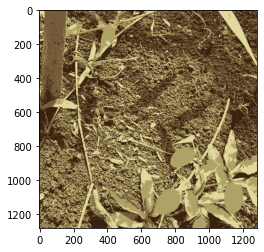

In [ ]:
path_sample = '/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset/dataset/gambar27.jpeg'
sample_1 = os.path.join(path_sample)
sample_1=plt.imread(sample_1)
pixel_vals = sample_1.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.85)
k = 4
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
segmented_image1 = centers[labels.flatten()]
segmented_image1 = segmented_image1.reshape((sample_1.shape))
segmented_image1
plt.imshow(segmented_image1)

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.util import img_as_float
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from imageio import imsave
from cv2 import imwrite

path_sample = '/content/drive/MyDrive/Colab Notebooks/segmentasiCitraSrmKM/dataset/dataset/gambar27.jpeg'
sample_fcm1 = os.path.join(path_sample)
sample_fcm1 = plt.imread(sample_fcm1)
sample_fcm1 = img_as_float(sample_fcm1)
x = np.reshape(sample_fcm1,(sample_fcm1.shape[0]*sample_fcm1.shape[1],3),order='F')
cluster_n = 4
expo = 2 
min_err = 0.001 
max_iter = 300 
verbose = 0
m, c = fcm(x, cluster_n,expo, min_err,max_iter,verbose)
m = np.reshape(m,(sample_fcm1.shape[0],sample_fcm1.shape[1]),order='F')
simg = keep_center(sample_fcm1,m,c,verbose)      
segmented = np.uint8(simg)
segmented_sample_fcm1 = centers[labels.flatten()]
segmented_sample_fcm1 = segmented_sample_fcm1.reshape((sample_fcm1.shape))
segmented_sample_fcm1


array([[[175, 162, 102],
        [175, 162, 102],
        [175, 162, 102],
        ...,
        [ 57,  33,  15],
        [ 57,  33,  15],
        [ 57,  33,  15]],

       [[225, 217, 157],
        [225, 217, 157],
        [225, 217, 157],
        ...,
        [ 57,  33,  15],
        [ 57,  33,  15],
        [ 57,  33,  15]],

       [[225, 217, 157],
        [225, 217, 157],
        [225, 217, 157],
        ...,
        [ 57,  33,  15],
        [ 57,  33,  15],
        [ 57,  33,  15]],

       ...,

       [[175, 162, 102],
        [175, 162, 102],
        [175, 162, 102],
        ...,
        [ 57,  33,  15],
        [ 57,  33,  15],
        [ 57,  33,  15]],

       [[175, 162, 102],
        [175, 162, 102],
        [175, 162, 102],
        ...,
        [ 57,  33,  15],
        [ 57,  33,  15],
        [ 57,  33,  15]],

       [[175, 162, 102],
        [175, 162, 102],
        [175, 162, 102],
        ...,
        [117,  92,  58],
        [ 57,  33,  15],
        [ 57,  33,  15]]